In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SSSBBBBB'
m='SNWD'

## Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [28]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [22]:
import ipywidgets as ipyw
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

In [3]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib


/Users/Garrett/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Circle', 'Polygon', 'Rectangle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   3126.0| 39.3333|-106.3333|       SNWD|USC00058212|     0|[5E 60 90 60 C4 6...|1949.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       SNWD|USC00058212|     1|[28 5B F0 5B 5C 5...|1950.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       SNWD|USC00058212|     0|[5C 61 5C 61 8E 6...|1951.0|SSSBBBBB|
|   3126.0| 39.3333|-106.3333|       SNWD|USC00058212|     0|[75 65 75 65 5C 6...|1952.0|SSSBBBBB|
|   2019.0| 39.3667|-107.0333|       SNWD|USC00050514|     0|[C0 58 C0 58 28 5...|1967.0|SSSBBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

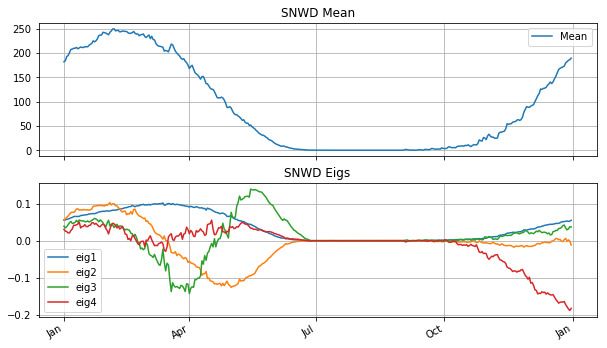

In [7]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=4
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [8]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

### plot the percent of residual variance on average

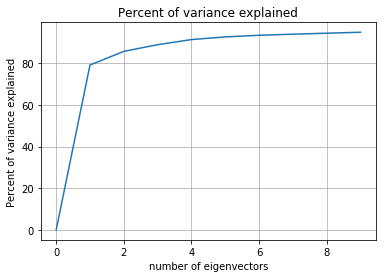

In [9]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [10]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
def ipyplotter(table):
    min_lat,max_lat,min_long,max_long = box = (39.1014, 39.8227, -108.7339, -105.1171)
    center = [(min_lat+max_lat)/2, (min_long+max_long)/2]

    center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
    zoom = 9

    m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

    r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
    m += r

    lat_margin=(max_lat-min_lat)/4
    long_margin=(max_long-min_long)/4
    circles = []
    for index,row in table.iterrows():
        _lat=row['latitude']
        _long=row['longitude']
#         _count=row['count(station)']
#         _coef=row[_avg]
        # taking sqrt of count so that the  area of the circle corresponds to the count
        c = Circle(location=(_lat,_long), radius=600, weight=1,
                color='#F00', opacity=0.8, fill_opacity=0.4,
                fill_color=colors[0])
        circles.append(c)
        m.add_layer(c)
        
        
        
#     zoom = 9
#     m = Map(default_tiles=TileLayer(opacity=0.6), center=center, zoom=zoom)
#     r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
#     m += r
#     lat_margin=(max_lat-min_lat)/4
#     long_margin=(max_long-min_long)/4
#     for index,row in table.iterrows():
#         _lat=row['latitude']
#         _long=row['longitude']
#         for col in range(4):
#             _coef=row[col]
#             if np.isnan(_coef):
#                 continue
#             r=abs(_coef)/5
#     #         print r
#             color=colors[col]
#             signs=[[+1,+1],[+1,-1],[-1,-1],[-1,+1]]
#             lat_sign,long_sign=signs[col]
#             triangle=[(_lat,_long),(_lat+lat_sign*r,_long),(_lat,_long+long_sign*r),(_lat,_long)]
#             if _coef<0:
#                 poly= Polygon(locations=triangle, weight=0,
#                         color=color, opacity=0, fill_opacity=0.7,
#                         fill_color=color)
#             else:
#                 poly= Polygon(locations=triangle, weight=1,
#                         color=color, opacity=0.8, fill_opacity=0,
#                         fill_color=color)
#             m +=poly   
    return m

In [11]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [12]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1350
after filter 564


In [13]:
# Sort entries by increasing values of ers_3
# df3=df3.sort(df3.res_3,ascending=True)

In [14]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10), coef='coeff_1'):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='%s / %d    %s,\n%s=%3.2f,r1=%3.2f,\n r2=%3.2f,r3=%3.2f,r4=%3.2f'\
                   %(row['station'],row['year'],row['measurement'],coef,row[coef],row['res_1'],row['res_2'],row['res_3'],row['res_4'])
#             print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],interactive=False, Title = _title)
    return None


#### Different things to try
The best/worst rows in terms of res_mean,res_1, res_2, res_3

The rows with the highest lowest levels of coeff1, coeff2, coeff3, when the corresponding residue is small.

In [15]:
df3.columns

['coeff_1',
 'coeff_2',
 'coeff_3',
 'coeff_4',
 'elevation',
 'label',
 'latitude',
 'longitude',
 'measurement',
 'res_1',
 'res_2',
 'res_3',
 'res_4',
 'res_mean',
 'station',
 'total_var',
 'undefs',
 'vector',
 'year']

In [29]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
def ipyplotter_2(table_list):
    min_lat,max_lat,min_long,max_long = box = (39.1014, 39.8227, -108.7339, -105.1171)
    center = [(min_lat+max_lat)/2, (min_long+max_long)/2]

    center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
    zoom = 4

    m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

    r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
    m += r

    lat_margin=(max_lat-min_lat)/4
    long_margin=(max_long-min_long)/4
    circles = []
    for iii in range(len(table_list)):
        for index,row in table_list[iii].iterrows():
            _lat=row['latitude']
            _long=row['longitude']
            c = Circle(location=(_lat,_long), radius=1200, weight=1,
                    color=colors[iii], opacity=0.8, fill_opacity=0.8,
                    fill_color=colors[iii])
            circles.append(c)
            m.add_layer(c)
        
        
    return m

In [17]:
rows3=df3.sort('coeff_1',ascending=False).limit(2).toPandas()
# rows1=df4.show(2)
# df4.select('coeff_2','res_2').show(4)
# rows3

In [18]:
tab_list_names = ['Max Coeff_1','Min Coeff_1','Max Coeff_2','Min Coeff21','Max Coeff_3','Min Coeff_3','Max Coeff_4','Min Coeff_4']
tab_list = []
for ii in ['coeff_1','coeff_2','coeff_3','coeff_4']:

    tab_list.append(df3.sort(ii, ascending=False).limit(4).toPandas())
    tab_list.append(df3.sort(ii, ascending=True).limit(4).toPandas())


In [30]:
ipyplotter_2(tab_list)

In [123]:
ipyplotter(df3.sort('coeff_4', ascending=True).limit(4).toPandas())

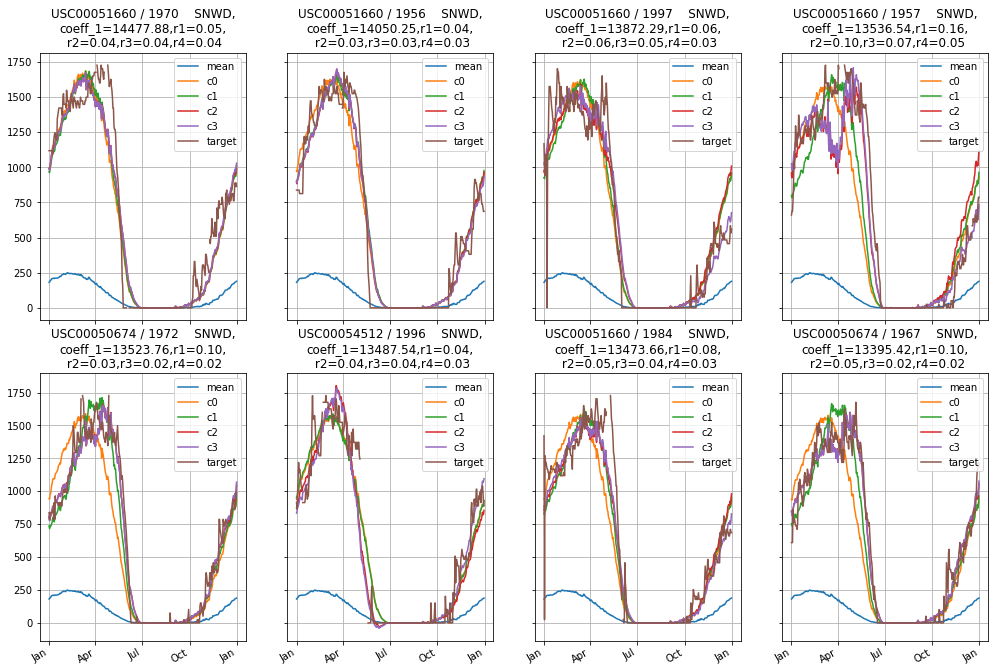

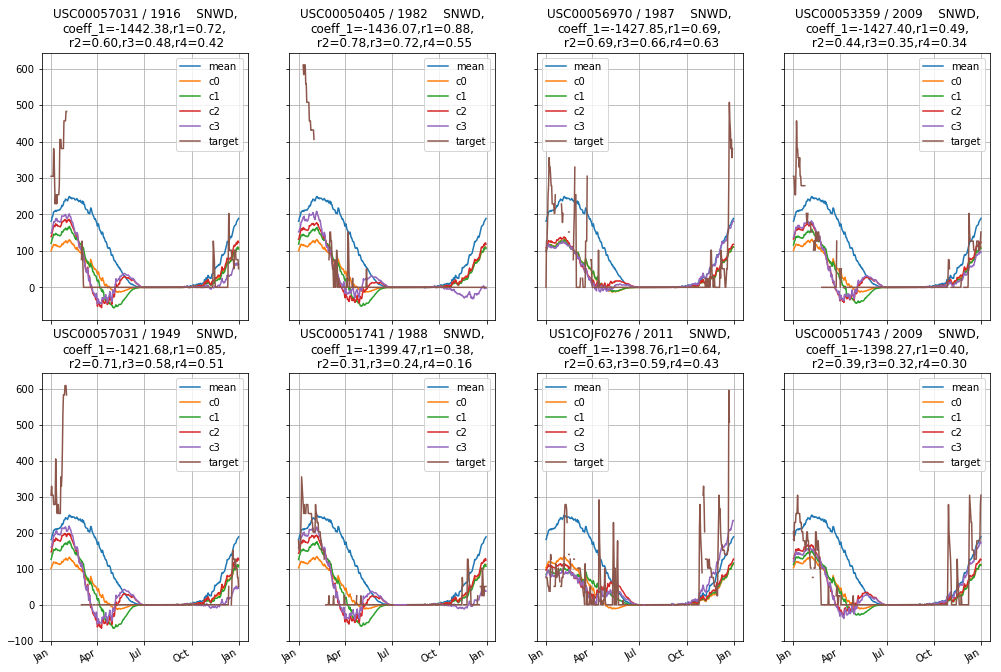

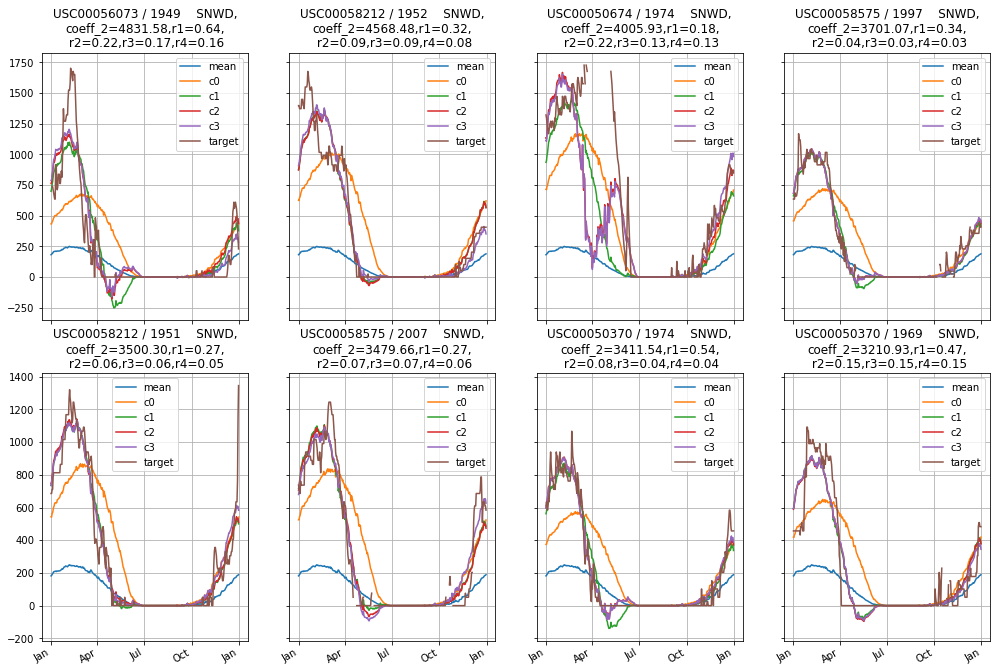

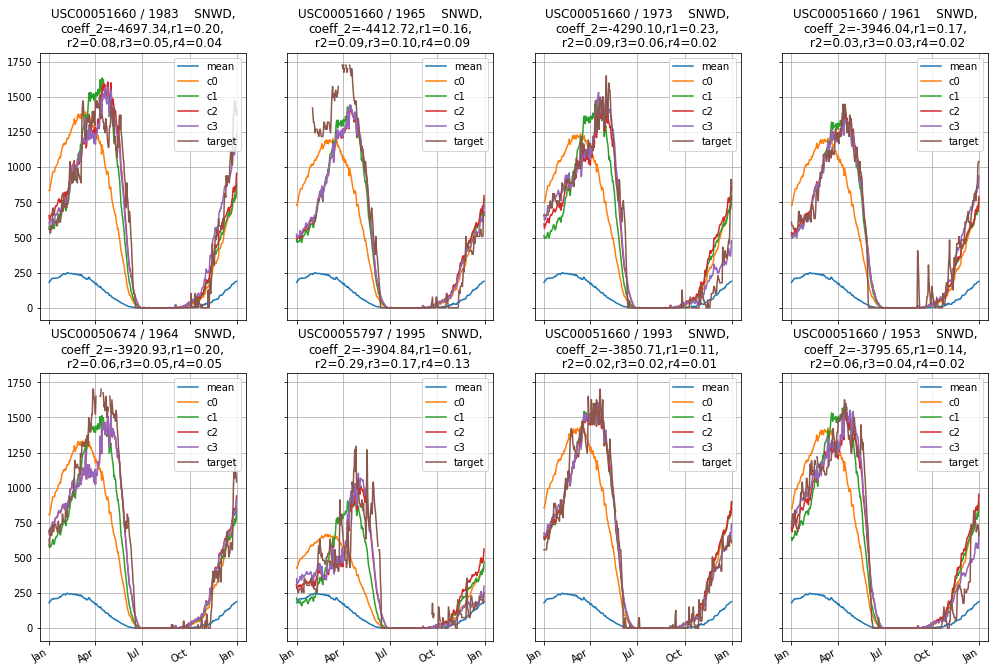

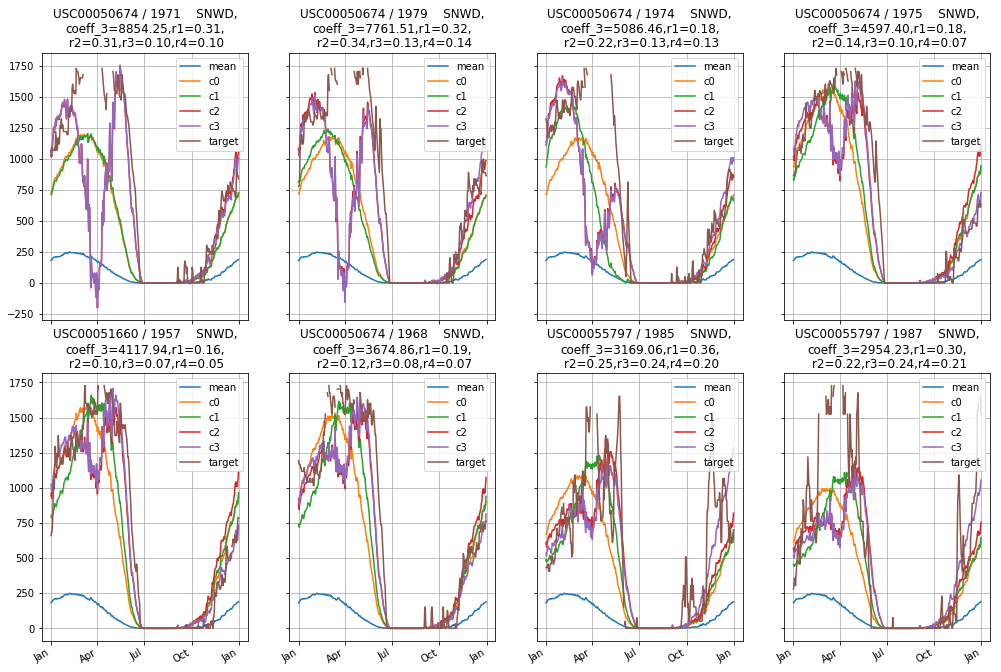

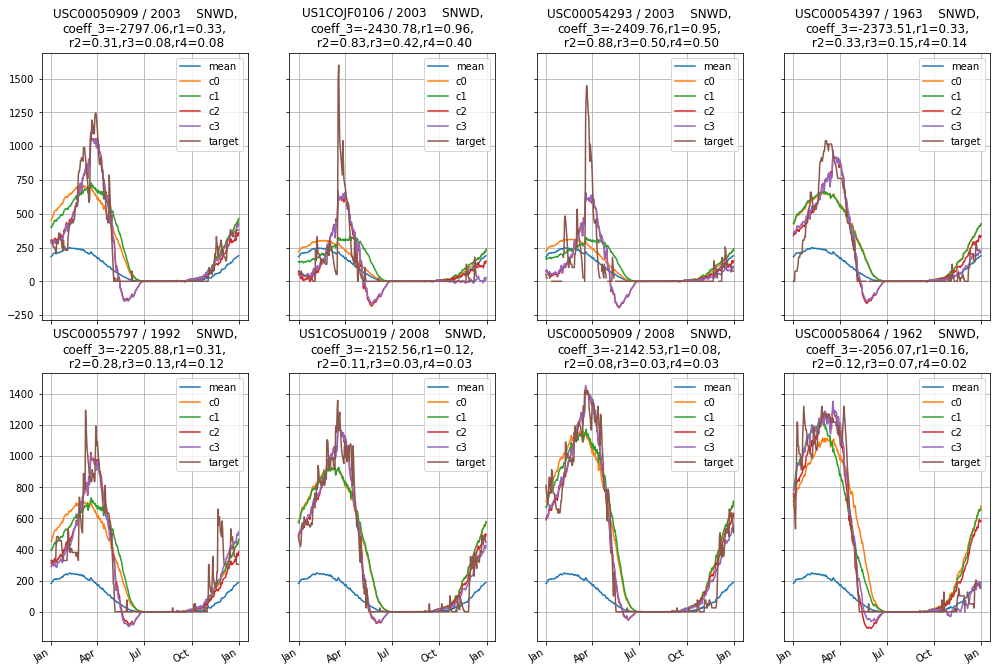

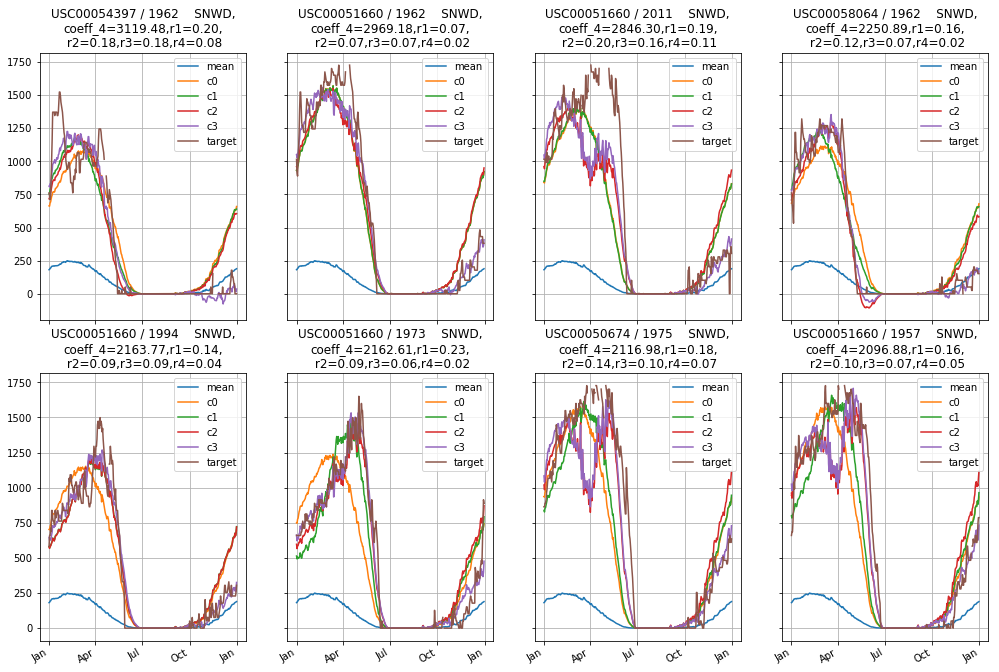

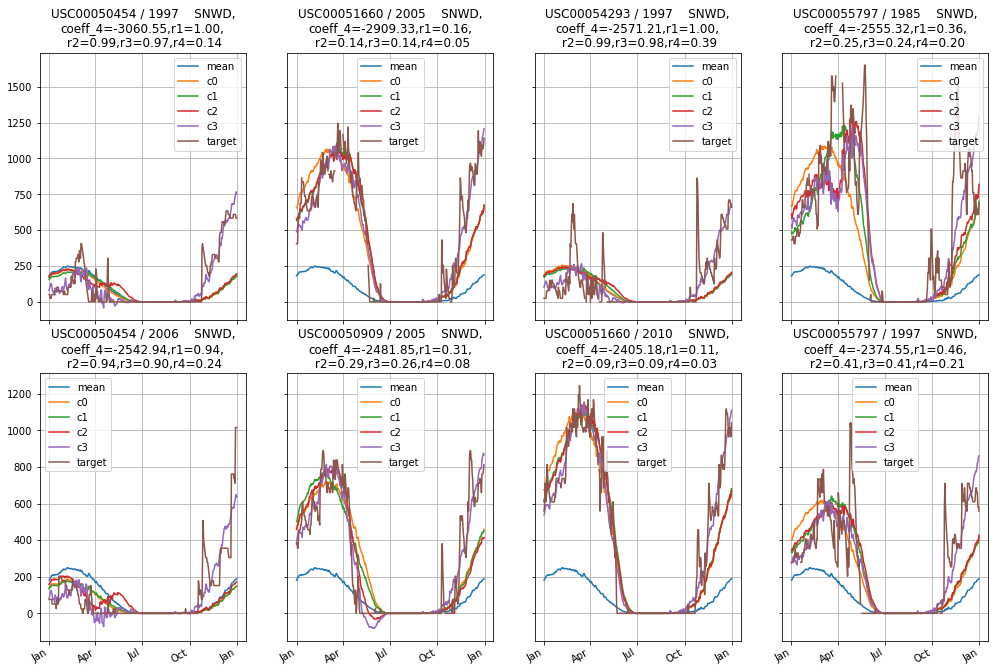

In [28]:
for ii in ['coeff_1','coeff_2','coeff_3','coeff_4']:
#     print(ii + ' Most Positive')
    dff = df3.sort(ii, ascending=False).take(8)
    plot_recon_grid(dff, figsize = (17,12),row_n=2,coef = ii)
#     pdff = df3.sort(ii, ascending=False).limit(4).toPandas()
#     ipyplotter(pdff)
#     print(ii + ' Most Negative')
    dfff = df3.sort(ii,ascending=True).take(8)
    plot_recon_grid(dfff, figsize = (17,12),row_n=2,coef = ii)
#     pdfff = df3.sort(ii,ascending=True).limit(4).toPandas()
#     ipyplotter(pdfff)

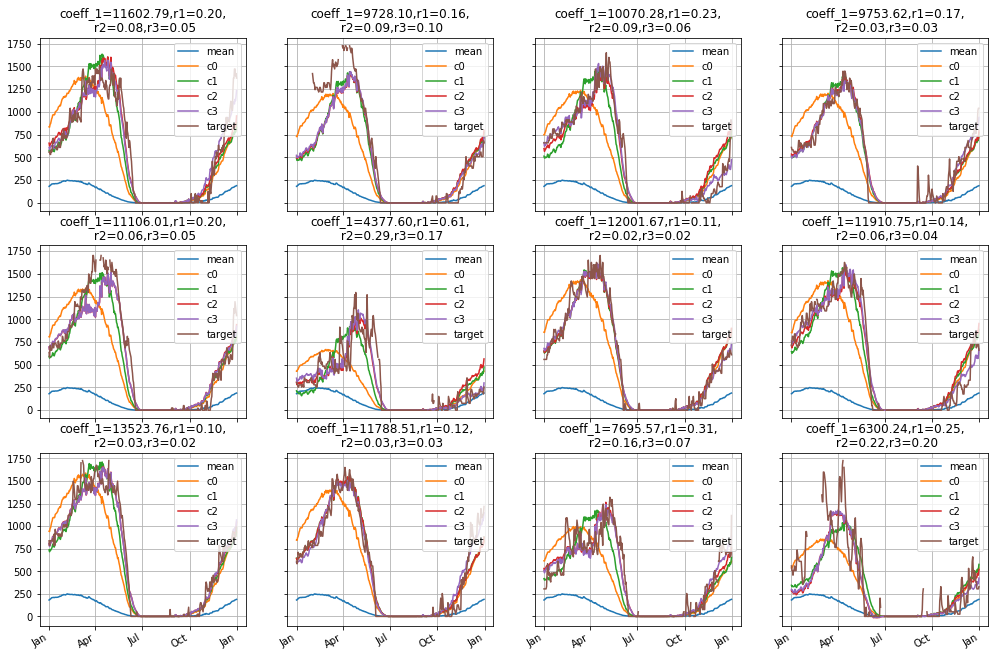

In [39]:
plot_recon_grid(rows1, figsize = (17,12))

In [15]:
# df3.sort?

In [16]:
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_2,ascending=False)
rows2=df5.take(12)
df5.select('coeff_2','res_2').show(4)

+------------------+--------------------+
|           coeff_2|               res_2|
+------------------+--------------------+
| 4831.579538780727|  0.2192170132412499|
| 4568.478078483509| 0.09256637997072555|
|4005.9301685027062|  0.2179637981176179|
|3701.0656712125506|0.042674011795838955|
+------------------+--------------------+
only showing top 4 rows



0 0 0.64,r1=0.64,r2=0.22,r3=0.17 Axes(0.125,0.657941;0.168478x0.222059)
0 1 0.66,r1=0.32,r2=0.09,r3=0.09 Axes(0.327174,0.68;0.168478x0.2)
0 2 0.74,r1=0.18,r2=0.22,r3=0.13 Axes(0.529348,0.68;0.168478x0.2)
0 3 0.55,r1=0.34,r2=0.04,r3=0.03 Axes(0.731522,0.68;0.168478x0.2)
1 0 0.59,r1=0.27,r2=0.06,r3=0.06 Axes(0.125,0.44;0.168478x0.2)
1 1 0.58,r1=0.27,r2=0.07,r3=0.07 Axes(0.327174,0.44;0.168478x0.2)
1 2 0.50,r1=0.54,r2=0.08,r3=0.04 Axes(0.529348,0.44;0.168478x0.2)
1 3 0.54,r1=0.47,r2=0.15,r3=0.15 Axes(0.731522,0.44;0.168478x0.2)
2 0 0.50,r1=0.44,r2=0.07,r3=0.06 Axes(0.125,0.2;0.168478x0.2)
2 1 0.49,r1=0.63,r2=0.18,r3=0.13 Axes(0.327174,0.2;0.168478x0.2)
2 2 0.51,r1=0.54,r2=0.16,r3=0.12 Axes(0.529348,0.2;0.168478x0.2)
2 3 0.61,r1=0.22,r2=0.08,r3=0.07 Axes(0.731522,0.2;0.168478x0.2)


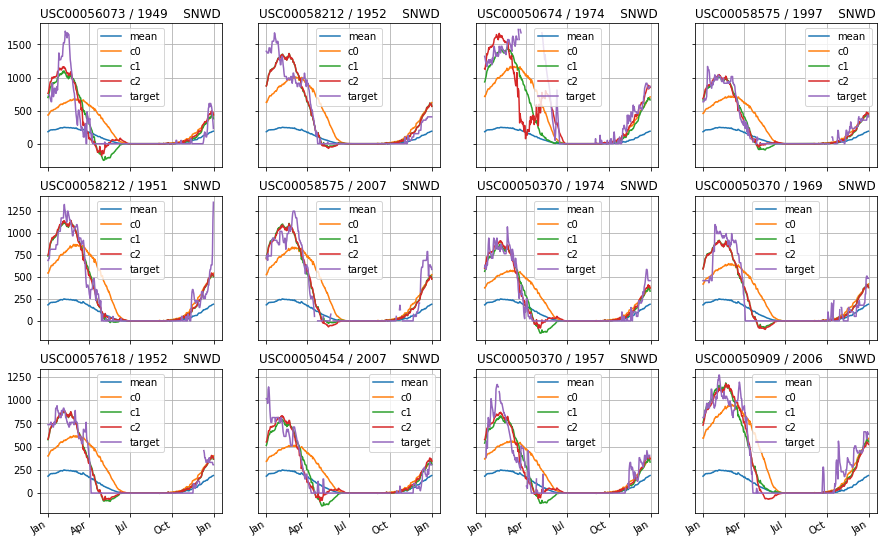

In [27]:
plot_recon_grid(rows2)

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

residual normalized norm  after mean: 0.63913031418
residual normalized norm  after mean + top eigs: [ 0.64344963  0.21921701  0.17044347]


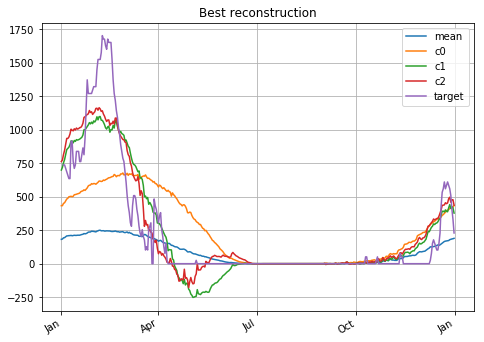

In [18]:
row=rows2[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [64]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,(1+1./(len(vals))),1./(len(vals)))
    vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

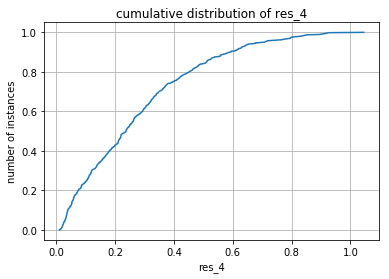

In [127]:
plot_CDF('res_4')

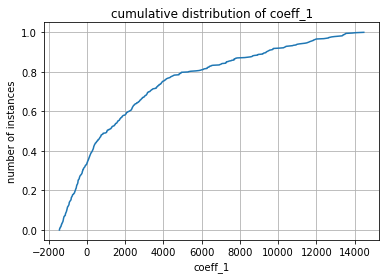

In [65]:
plot_CDF('coeff_1')

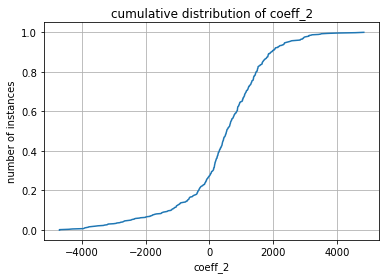

In [21]:
plot_CDF('coeff_2')

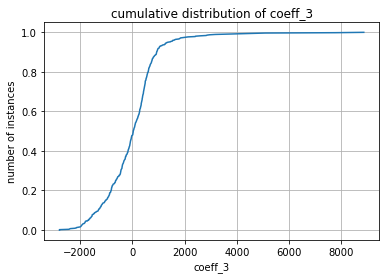

In [66]:
plot_CDF('coeff_3')

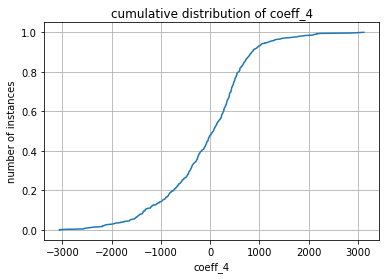

In [67]:
plot_CDF('coeff_4')

In [22]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [23]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
4.5M	../../Data/Weather/US_Weather_SSSBBBBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.1M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.1M	../../Data/Weather/decon_SSSBBBBB_PRCP.parquet
2.3M	../../Data/Weather/decon_SSSBBBBB_SNWD.parquet


In [24]:
sc.stop()